In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft,fftfreq,fftshift

In [165]:
# Now that the simplified version works, I want to build a more general version of this.
# This includes a different number of substates, differentiation between the transitions that model the refractory period and the last transition

def generate_residency_times(transition_rate: int, number_of_substates: int):
    residency_times = []
    rng = np.random.default_rng()
    residency_times = rng.exponential(scale = (1/transition_rate),size = number_of_substates)
    return residency_times

def gillespie_simulation_refactored(number_of_substates: list, transition_rates: list, refractory_periods: list, total_time: float, delta_t: float, perturbation_frequency = 0.0, epsilon = 0.0):
    """
    Simulates the two-state renewal process using the Gillespie Algorithm.

    This event-driven method simulates one state transition at a time, making it
    flexible for handling time-dependent transition rates (perturbations).

    Args:
        number_of_substates: A list with the number of substates for each chain.
        transition_rates: A list with the reset transition rates.
        refractory_periods: A list with the refractory periods for each chain.
        total_time: The total duration of the simulation.
        delta_t: The desired time step for the final output time series.

    Returns:
        A tuple (time_sequence, state_sequence) containing the regularly sampled
        time and state sequences, matching the format of your original function.
    """
    # --- 1. Setup and Parameter Calculation ---
    num_states_A = number_of_substates[0]
    num_states_B = number_of_substates[1]
    total_states = num_states_A + num_states_B

    # Rates for transitions *within* each linear chain
    rate_substates_A = (num_states_A - 1) / refractory_periods[0]
    rate_substates_B = (num_states_B - 1) / refractory_periods[1]

    # Rates for the "reset" jumps between chains
    rate_A_to_B = transition_rates[0]
    rate_B_to_A = transition_rates[1]

    # --- 2. Gillespie Simulation Loop (Event-Driven) ---
    current_time = 0.0
    current_state = 0  # We use integer states: 0 to N_A-1 for chain A, N_A to N-1 for chain B

    # Store the raw, irregularly sampled output of the simulation
    raw_times = [0.0]
    raw_states = [current_state]

    while current_time < total_time:
        # Determine the single possible transition and its rate from the current state
        if 0 <= current_state < num_states_A - 1:
            # We are in the middle of chain A
            rate = rate_substates_A
            next_state = current_state + 1
        elif current_state == num_states_A - 1:
            # We are at the end of chain A, about to reset to B
            rate = rate_A_to_B
            next_state = num_states_A  # Jump to the start of chain B
        elif num_states_A <= current_state < total_states - 1:
            # We are in the middle of chain B
            rate = rate_substates_B
            next_state = current_state + 1
        elif current_state == total_states - 1:
            # We are at the end of chain B, about to reset to A
            rate = rate_B_to_A
            next_state = 0  # Jump to the start of chain A

        # *** THIS IS WHERE YOU WOULD ADD A TIME-DEPENDENT PERTURBATION ***
        # For example, to perturb the 9 -> 10 transition (in a 10+10 model):
        omega_d = perturbation_frequency
        if current_state == 9:
             rate += epsilon * np.cos(omega_d * current_time)
             rate = max(0, rate) # Ensure rate is non-negative

        if rate <= 0:  # No possible transitions out of this state
            break

        # Draw the time to the next event from an exponential distribution
        tau = -np.log(np.random.random()) / rate

        # Update time and state
        current_time += tau
        current_state = next_state

        # Record the raw event
        raw_times.append(current_time)
        raw_states.append(current_state)

    # --- 3. Post-Processing: Resample to a Regular Time Grid ---
    # This section converts the raw event data into the fixed-timestep format
    # that your original function produced.

    time_sequence = np.arange(0, total_time, delta_t)
    state_sequence_int = np.zeros(len(time_sequence), dtype=int)

    # Find which raw time interval each regular time point falls into
    event_indices = np.searchsorted(raw_times, time_sequence, side='right') - 1

    # Fill the sequence with the state that was active at each time point
    for i in range(len(time_sequence)):
        state_sequence_int[i] = raw_states[event_indices[i]]

    # --- 4. Map Integer States back to Your Original Float Representation ---
    # This ensures the output is identical in format to your original function.
    state_sequence_float = np.zeros(len(time_sequence), dtype=float)
    for i in range(len(state_sequence_int)):
        state = state_sequence_int[i]
        if 0 <= state < num_states_A:
            # Map to states in chain A (e.g., -1.0, -0.9,...)
            state_sequence_float[i] = -1.0 + state / num_states_A
        else:
            # Map to states in chain B (e.g., 0.1, 0.2,...)
            state_sequence_float[i] = (state - num_states_A + 1) / num_states_B
            
    return time_sequence, state_sequence_float



In [166]:
# def function that hides the sequence of substates and identifies them with their "parent state" -1 or 1
def reduce_states(sample_states):
    """
    Takes as input the array that contains the sequence of plotable states and identifies them with super states.

    """
    sample_state_reduced = []
    
    for i,state in enumerate(sample_states):
        if state < 0:
            sample_state_reduced.append(-1)
        else:
            sample_state_reduced.append(1)
    return sample_state_reduced

def two_state_process_reduced(gillespie_simulation_refactored, *args, **kwargs):
    time_sequence,state_sequence = gillespie_simulation_refactored(*args, **kwargs)
    state_sequence = reduce_states(state_sequence)
    return time_sequence,state_sequence

#the following function guarantees that the eigenvector that is chosen is a probability density, i.e. positive and normed to one
def norm_to_probability_density(x: np.array):
    if np.argmax(x) < 0:                   
        x = -x            
    x = 1/(np.sum(x)) * x
    return x

In [372]:
def build_generator_matrix(number_of_substates: list, transition_rates: list, refractory_periods: list):
    """
    Constructs the generator matrix (L) for the two-state renewal process
    with linear chains to model refractory periods.
    
    Args:
        number_of_substates (list): [N, M], the number of substates for state A and B.
        transition_rates (list): The final transition rates out of state A and B.
        refractory_periods (list): The desired mean refractory period for state A and B.

    Returns:
        array: The (N+M)x(N+M) generator matrix L.
    """
    #Define relevant parameters
    N = number_of_substates[0]
    M = number_of_substates[1]

    total_states = N + M

    transition_rates_substates_A = (N-1) / refractory_periods[0]
    transition_rates_substates_B = (M-1) / refractory_periods[1]

    transition_rate_final_A = transition_rates[0]
    transition_rate_final_B = transition_rates[1]

    #Initialize matrix
    L = np.zeros((total_states,total_states))

    for i in range(N-1):
        L[i,i] = (-1 * transition_rates_substates_A)
        L[i+1,i] = transition_rates_substates_A
    
    L[N-1,N-1] = (-1 * transition_rate_final_A)
    L[N,N-1] = transition_rate_final_A

    for i in range(N,N+M-1):
        L[i,i] = (-1 * transition_rates_substates_B)
        L[i+1,i] = transition_rates_substates_B

    L[N+M-1,N+M-1] = (-1 * transition_rate_final_B)
    L[0,N+M-1] = transition_rate_final_B

    return L


def calculate_and_order_eigenspectrum(L: np.array):
    """
    Calculates and plots the eigenvalues of the generator matrix L.

    Args:  generator matrix L
    """
    #calculate lefthand eigenvalues
    eigenvalues_left_raw, eigenvectors_left = np.linalg.eig(L.T)     #since we want the lefthand eigenvectors, we take transpose the matrix here
    #Order eigenvalues by magnitude of real part. The resulting array starts with eigenvalues that have the most negative real part. 
    index_ordering = np.argsort(eigenvalues_left_raw.real)
    eigenvalues_left = eigenvalues_left_raw[index_ordering]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_left)-1):
        if eigenvalues_left[i].real == eigenvalues_left[i+1].real:
            if eigenvalues_left[i].imag > eigenvalues_left[i+1].imag:
                temp = index_ordering[i]
                index_ordering[i] = index_ordering[i+1]
                index_ordering[i+1] = temp
            else: continue
    eigenvalues_left = eigenvalues_left_raw[index_ordering]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_left = []
    for i in index_ordering:
        ordered_eigenvectors_left.append(eigenvectors_left[:,i])

    #Norm stationary left eigenvector to all ones
    for i in range(len(ordered_eigenvectors_left[-1])):
        ordered_eigenvectors_left[-1][i] = np.abs(1/(ordered_eigenvectors_left[-1][i]) * ordered_eigenvectors_left[-1][i])
    

    ################################################

    #calculate righthand eigenvalues
    eigenvalues_right_raw, eigenvectors_right = np.linalg.eig(L)
    
    idx_order = np.argsort(eigenvalues_right_raw.real)
    eigenvalues_right = eigenvalues_right_raw[idx_order]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_right)-1):
        if eigenvalues_right[i].real == eigenvalues_right[i+1].real:
            if eigenvalues_right[i].imag > eigenvalues_right[i+1].imag:
                temp = idx_order[i]
                idx_order[i] = idx_order[i+1]
                idx_order[i+1] = temp
            else: continue
    eigenvalues_right = eigenvalues_right_raw[idx_order]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_right = []
    for i in idx_order:
        ordered_eigenvectors_right.append(eigenvectors_right[:,i])

    #Norm stationary right eigenvector so that it is a probability distribution
    ordered_eigenvectors_right[-1] = norm_to_probability_density(ordered_eigenvectors_right[-1])

    #Norm the left eigenvectors Q_i to unit variance, as detailed in the paper eq. 9
    for i in range(len(ordered_eigenvectors_left)-1):
        variance = 0
        for j in range(len(ordered_eigenvectors_left[i])):
            variance += np.abs(ordered_eigenvectors_left[i][j])**2 * ordered_eigenvectors_right[-1][j]
        ordered_eigenvectors_left[i] = (1/np.sqrt(variance)) * ordered_eigenvectors_left[i]

    #Enforce biorthogonality 
    for i in range(len(ordered_eigenvectors_right)-1):
        dot_product = ordered_eigenvectors_right[i]@ordered_eigenvectors_left[i]
        ordered_eigenvectors_right[i] = (1/dot_product) * ordered_eigenvectors_right[i]

    return eigenvalues_left,ordered_eigenvectors_left,ordered_eigenvectors_right

def analyzing_and_plotting_eigenspectrum(ordered_eigenvalues, ordered_eigenvectors_left, ordered_eigenvectors_right):
    stationary_eigenvalue = ordered_eigenvalues[-1]

    #the eigenvalue of interest is the eigenvalue with the the largest non-zero real part
    lambda_1 = ordered_eigenvalues[-2]
    mu_1 = lambda_1.real
    omega_1 = lambda_1.imag

    #stationary left eigenvector
    Q_0 = ordered_eigenvectors_left[-1]
    #the following line guarantee that the eigenvalue that is chosen is a probability density, i.e. positive and normed to one

    #the left eigenvector Q_1 that corresponds to the lambda_1
    Q_1 = ordered_eigenvectors_left[-2]
    #Q_1 = norm_to_probability_density(Q_1)
    
    sum_entries_Q_0 = np.sum(Q_0)
    sum_entries_Q_1 = np.sum(Q_1)

    #stationary right eigenvector
    P_0 = ordered_eigenvectors_right[-1]
    #P_0 = norm_to_probability_density(P_0)

    #the right eigenvector P_1 that corresponds to the lambda_1
    P_1 = ordered_eigenvectors_right[-2]
    #P_1 = norm_to_probability_density(Q_1)
    
    sum_entries_P_0 = np.sum(P_0)
    sum_entries_P_1 = np.sum(P_1)


    print("-" * 30)
    print(f"Number of eigenvalues: {len(ordered_eigenvalues)}")
    print(f"Stationary Eigenvalue: {stationary_eigenvalue:.4f}")
    print(f"Oscillatory Eigenvalue (λ₁): {lambda_1:.4f}")
    print(f"Quality factor: {np.abs(omega_1/mu_1)}")
    print("-" * 30)
    print(f"Stationary lefthand Eigenvector: {Q_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary lefthand eigenvector: {sum_entries_Q_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (Q₁): {Q_1}")
    print(" " * 30)
    print(f"Sum of elements of Q₁: {sum_entries_Q_1}")
    print("-" * 30)
    print(f"Stationary righthand Eigenvector: {P_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary righthand eigenvector: {sum_entries_P_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (P₁): {P_1}")
    print(" " * 30)
    print(f"Sum of elements of P₁: {sum_entries_P_1}")


    #Plotting

    # Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot all eigenvalues
    ax.scatter(ordered_eigenvalues.real, ordered_eigenvalues.imag, c='teal', alpha=0.6, label='Other Eigenvalues')
    ax.scatter(ordered_eigenvalues.real, -ordered_eigenvalues.imag, c='teal', alpha=0.6) # Plot conjugates

    #Highlight eigenvalue with largest non-zero real part
    ax.scatter(lambda_1.real, lambda_1.imag, c='red', alpha=1, s=150, label=f'$\lambda_1$ = {mu_1:.2f} + {omega_1:.2f}i')
    ax.scatter(lambda_1.real, -lambda_1.imag, c='red', alpha=1, s=150) # Plot conjugates

    # Annotate the plot
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.set_xlim(-18, 0 + 0.5)
    ax.set_xlabel("Re(λ)", fontsize=14)
    ax.set_ylabel("Im(λ)", fontsize=14)
    ax.set_title("Eigenvalue Spectrum of the Generator Matrix", fontsize=16, weight='bold')
    ax.legend(fontsize=12)
    ax.grid(True)

    plt.show()


In [168]:
#calculate the conditional transition probability from the obtained eigenvetors
def transition_probability(eigenvalues: list, left_eigenvectors: list, right_eigenvectors: list ,initial_state: int,target_state: int,time: float):
        spectral_sum = 0
        for i in range(len(left_eigenvectors)-1):
            spectral_sum += np.exp(eigenvalues[i] * time) * right_eigenvectors[i][target_state] * left_eigenvectors[i][initial_state]
        return right_eigenvectors[-1][target_state] + spectral_sum

In [169]:
#define function that calculates power spectrum for given sequence of time and states by averaging over many realizations of the process
def power_spectrum(process_generator, realizations: int, *args, **kwargs):
    #process generator must return two arrays, one time sequence and one state sequence
    #call process generator once to initialize variables:
    time_sequence,state_sequence = process_generator(*args,**kwargs)
    #state_sequence = reduce_states(state_sequence)                              ####   if this line is uncommented the power spectrum of the superstates is calculated 
    number_sample_points = len(time_sequence)
    dt = time_sequence[1]-time_sequence[0]
    average = np.zeros(number_sample_points)
    #calculate first iteration with initialized variables
    ft_state_sequence = fft(state_sequence)*dt
    average += np.abs(ft_state_sequence)**2

    #calculate ensemble average over remaining realizations
    for i in range(1,realizations):
        time_sequence,state_sequence = process_generator(*args,**kwargs)
        #state_sequence = reduce_states(state_sequence)                          ####   if this line is uncommented the power spectrum of the superstates is calculated
        ft_state_sequence = fft(state_sequence)*dt
        if len(average) == len(ft_state_sequence):
            average += np.abs(ft_state_sequence)**2
        else: 
            print(f'Flag for realisation {i}')
            print(f'Mismatch: {len(average)} is not equal to {len(ft_state_sequence)}')

    #calculate final outputs
    frequency_sequence = fftfreq(number_sample_points,dt)
    power_spectrum_sequence = average/(realizations * (len(time_sequence)*dt))

    return frequency_sequence,power_spectrum_sequence

In [170]:
def phase_reduction(state_sequence: list, Q_1: np.array):
    
    Q_1_sequence = np.zeros(len(state_sequence), dtype=np.complex128)

    
    for i in range(len(state_sequence)):
        #reconstruct the state index from the trajectory value
        ### this assumes that the initial state is -1 and the indexing increases monotonically until state 1 is reached, i.e. -1 has index 0 and 1 has index 19
        x = state_sequence[i]
        if x < 0:
            advancement = np.abs(x - state_sequence[0])
            state_index = int(10*advancement)
        elif x > 0:
            advancement = x
            state_index = int(10*advancement + 9)
        
        #assign calculated Q_1 value
        Q_1_sequence[i] = Q_1[state_index]
        
        complex_argument_Q_1 = np.angle(Q_1_sequence)

    return Q_1_sequence

def phase_reduced_process(time_sequence: list, state_sequence:list, Q_1: np.array):

    complex_argument_Q_1 = phase_reduction(state_sequence, Q_1)

    return time_sequence, complex_argument_Q_1


In [171]:
#the theoretically expected power spectrum of Q_1
def power_spectrum_theoretical_Q_1(eigenvalue: np.complex128, omega: float):
    mu_1 = eigenvalue.real
    omega_1 = eigenvalue.imag
    return (2*np.abs(mu_1)) / (mu_1**2 + (omega - omega_1)**2)

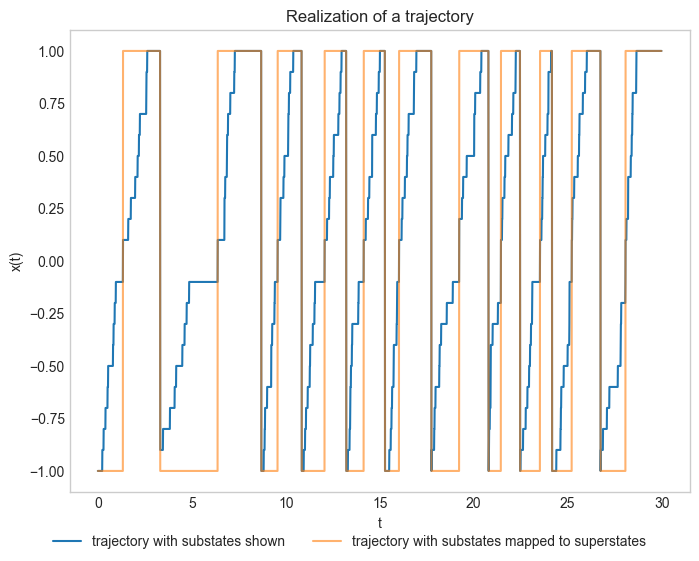

------------------------------
Number of eigenvalues: 20
Stationary Eigenvalue: -0.0000+0.0000j
Oscillatory Eigenvalue (λ₁): -0.5083+2.1053j
Quality factor: 4.142223222100159
------------------------------
Stationary lefthand Eigenvector: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
                              
Sum of elements of stationary lefthand eigenvector: (20+0j)
                              
Oscillatory Eigenvector (Q₁): [-1.1644088 -3.96443851e-15j -1.09865061-2.72385112e-01j
 -0.97288814-5.14005165e-01j -0.79770678-7.12561027e-01j
 -0.5859712 -8.58924336e-01j -0.35195493-9.47491614e-01j
 -0.1104362 -9.76314778e-01j  0.1241856 -9.47012768e-01j
  0.33870301-8.64481481e-01j  0.52179969-7.36429892e-01j
  1.1644088 +0.00000000e+00j  1.09865061+2.72385112e-01j
  0.97288814+5.14005165e-01j  0.79770678+7.12561027e-01j
  0.5859712 +8.58924336e-01j  0.35195493+9.47491614e-01j
  0.110436

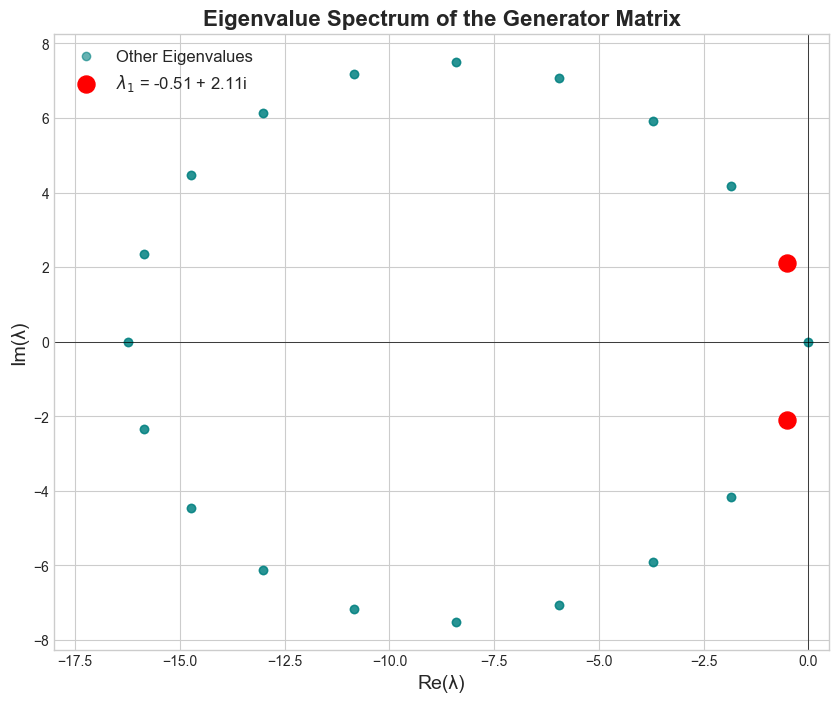

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


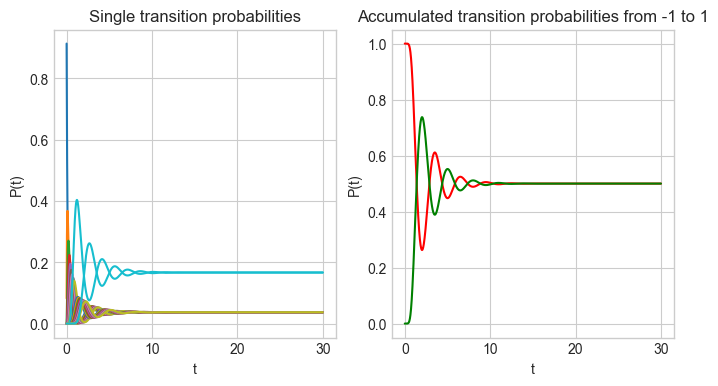

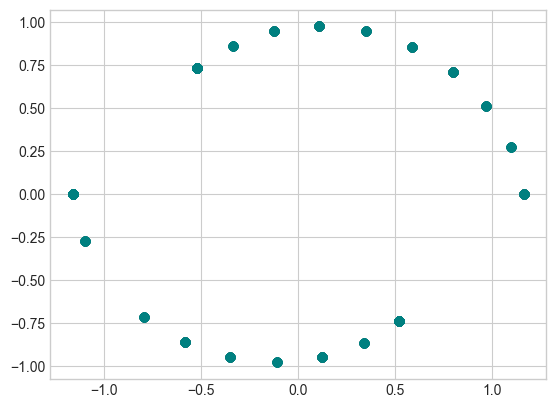

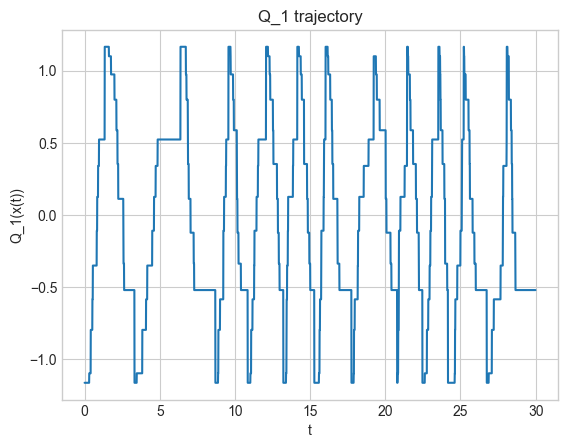

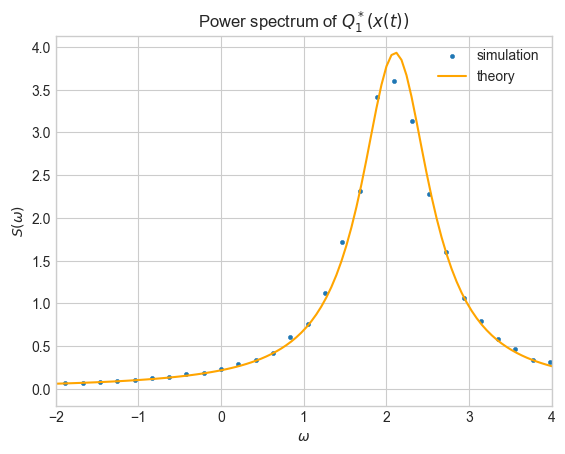

In [375]:
# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [2,2]
refractory_periods = [1,1]
total_time = 30
delta_t = 0.01

#Plot a trajectory for the given parameters
# Create a figure
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
generated_time_sequence, generated_state_trajectory = gillespie_simulation_refactored(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
ax1.set_title('Realization of a trajectory')
ax1.plot(generated_time_sequence, generated_state_trajectory, label='trajectory with substates shown')


#Plot reduced trajectory for the given parameters
reduced_state_trajectory = reduce_states(generated_state_trajectory)
ax1.plot(generated_time_sequence, reduced_state_trajectory, label='trajectory with substates mapped to superstates', alpha = 0.6)
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.grid(False)
fig.legend(loc='lower center', ncols = 2)
plt.show()

#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)

#Calculate eigenspectrum
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)
#Analyze and plot eigenspectrum
analyzing_and_plotting_eigenspectrum(eigenvals,Q,P)

#Plot transition probability over time for a specific pair of states
fig2, (ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
ax1.set_title('Single transition probabilities')
ax1.set_xlabel('t')
ax1.set_ylabel('P(t)')
for i in range(20):
    generated_transition_probability = [transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence]
    ax1.plot(generated_time_sequence,generated_transition_probability)

ax2.set_title('Accumulated transition probabilities from -1 to 1')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')

accum_transition_probability_A = [0 for time in generated_time_sequence]
accum_transition_probability_B = [0 for time in generated_time_sequence]
for i in range(10):
    accum_transition_probability_A = np.add(accum_transition_probability_A,[transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence])
    accum_transition_probability_B = np.add(accum_transition_probability_B,[transition_probability(eigenvals,Q,P,0,i+10,time+0.01) for time in generated_time_sequence])
ax2.plot(generated_time_sequence,accum_transition_probability_A,color='red')
ax2.plot(generated_time_sequence,accum_transition_probability_B,color='green')
plt.show()

#Perform transformation to Q_1:
Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])
plt.scatter(Q_1_sequence.real, Q_1_sequence.imag, c='teal', alpha=0.6)
plt.show()
#complex_argument = np.angle(Q_1_sequence)
plt.plot(generated_time_sequence,Q_1_sequence)
plt.title('Q_1 trajectory')
plt.xlabel('t')
plt.ylabel('Q_1(x(t))')
plt.show()

#Plot power spectrum Q_1(t):
f,S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])
accum = np.zeros(len(S)) 
for i in range(500):
    generated_time_sequence, generated_state_trajectory = gillespie_simulation_refactored(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
    S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])[1]
    accum += S
accum = 1/500 * accum
l = len(f)
f_shifted = fftshift(f)
#the theoretical formula is given for an angular frequency omega, so we have to convert the frequency into the angular frequency
omega = 2*np.pi * f_shifted
omega_plot = np.linspace(-2,4,100)
accum_shifted = fftshift(accum)
plt.scatter(omega,accum_shifted,linewidths=0.4, marker='.', label='simulation')
plt.plot(omega_plot,[power_spectrum_theoretical_Q_1(eigenvals[-2],x) for x in omega_plot],color='orange', label='theory')
plt.xlim(-2,4)
plt.title('Power spectrum of $Q_1^*(x(t))$')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.legend()
plt.show()


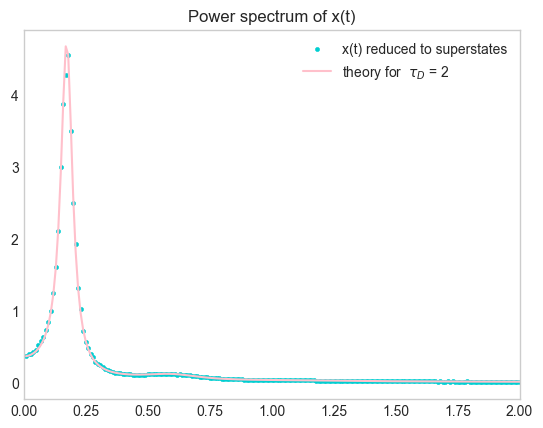

In [326]:
### Testing the power spectrum function for the trajectory and compare it with the non markovian version of the two state porcess
### Qualitatively the function works in this case but the scaling is of. On the point distribution it worked though. So the question remains if the function is off for some unknown reason
### or if our markovian process behaves differently

### ANSWER: The different value assignment of the substates changes the value of the power spectrum. If the substates are identified with its superstate, then the power spectra are the same

# Parameters
N = 50
M = 50
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 100
delta_t = 0.01
sim_params = [number_of_substates,number_of_substates,refractory_periods,total_time,delta_t]

# define theoretical power spectrum for non-markovian process that is approximated
def S_approx(f,tau_D):
    return 0.5 * (((1+1)**2 * 1**2)/(1+tau_D)) / (1 + np.cos(2*np.pi*f*tau_D) - 2*np.pi*f*1*np.sin(2*np.pi*f*tau_D) + 2*(np.pi*f*1)**2)

# define theoretical power spectrum for markovian process that we actually have
def S(f: float, refractory_periods:list, final_transition_rates:list, number_of_substates:list):
    N = number_of_substates[0]
    M = number_of_substates[1]
    lambda_A = (N-1)/refractory_periods[0]
    lambda_B = (M-1)/refractory_periods[1]
    lambda_N = final_transition_rates[0]
    lambda_M = final_transition_rates[1]
    FT_rho_A = (lambda_A / (2j*np.pi*f + lambda_A))**(N-1) * (lambda_N/(2j*np.pi*f + lambda_N))
    FT_rho_B = (lambda_B / (2j*np.pi*f + lambda_B))**(M-1) * (lambda_M/(2j*np.pi*f + lambda_M))

    val_super_A = 1
    val_super_B = -1
    mean_residency_time_A = refractory_periods[0] + 1/lambda_N
    mean_residency_time_B = refractory_periods[1] + 1/lambda_M

    S = (2*(val_super_A - val_super_B)**2)/((mean_residency_time_A + mean_residency_time_B)*(2*np.pi*f)**2)  * ((1-FT_rho_A)*(1-FT_rho_B)/(1-FT_rho_A*FT_rho_B)).real
    
    return S

f,psd = power_spectrum(gillespie_simulation_refactored,1000,number_of_substates,transition_rates,refractory_periods,total_time,delta_t)
psd2 = power_spectrum(two_state_process_reduced,1000,gillespie_simulation_refactored, number_of_substates,transition_rates,refractory_periods,total_time,delta_t)[1]
N = len(f)
plt.xlim(0,2)
#plt.scatter(f[1:N//2],psd[1:N//2],linewidths=0.4, marker='.', label='x(t)')
plt.scatter(f[1:N//2],psd2[1:N//2],linewidths=0.4, marker='.', color = 'darkturquoise', label = 'x(t) reduced to superstates')
#plt.plot(f[1:N//2],[S_approx(x,2) for x in f[1:N//2]], label=f'theory for non-markov approximation with $\\tau_D$ = {2}', color = 'orange')
plt.plot(f[1:N//2],[S(x,refractory_periods, transition_rates, number_of_substates) for x in f[1:N//2]], label=f'theory for  $\\tau_D$ = {2}', color = 'pink')
plt.title('Power spectrum of x(t)')
plt.legend()
plt.grid(False)
plt.show()

In [216]:
def measure_susceptibility_with_lockin(
    time_sequence, 
    observable_sequence, 
    driving_frequency, 
    epsilon, 
    transient_time
):
    """
    Measures the complex susceptibility from a perturbed time series using a
    numerical lock-in amplifier.

    Args:
        time_sequence: The array of regularly sampled time points.
        observable_sequence: The complex-valued time series of the Q*_1 observable.
        driving_frequency: The frequency (omega_d) of the sinusoidal perturbation.
        epsilon: The amplitude of the perturbation.
        transient_time: The initial duration to discard to ensure steady-state analysis.

    Returns:
        The measured complex susceptibility at the given driving frequency.
    """
    # --- Step A: Discard the initial transient part of the simulation ---
    # This ensures the system has reached a perturbed steady state.
    steady_state_start_index = np.argmin(np.abs(time_sequence - transient_time))
    
    steady_state_times = time_sequence[steady_state_start_index:]
    steady_state_Q_series = observable_sequence[steady_state_start_index:]

    # --- Step B: Generate the two reference signals ---
    ref_cos = np.cos(driving_frequency * steady_state_times)
    ref_sin = np.sin(driving_frequency * steady_state_times)

    # --- Step C: Multiply the signal by the references ("Mixing") ---
    in_phase_signal = steady_state_Q_series * ref_cos
    quadrature_signal = steady_state_Q_series * ref_sin

    # --- Step D: Average the results ("Filtering") ---
    # The time average isolates the DC component, filtering out all other noise.
    # The factor of 2 is a convention that arises from trigonometric identities.
    X = 2 * np.mean(in_phase_signal)
    Y = 2 * np.mean(quadrature_signal)

    # --- Step E: Reconstruct the complex susceptibility ---
    # The complex response is (X - iY). We divide by epsilon to get susceptibility.
    # The minus sign on the imaginary part is a convention from the Fourier transform.
    chi_measured = (X - 1j * Y) / epsilon
    
    return chi_measured

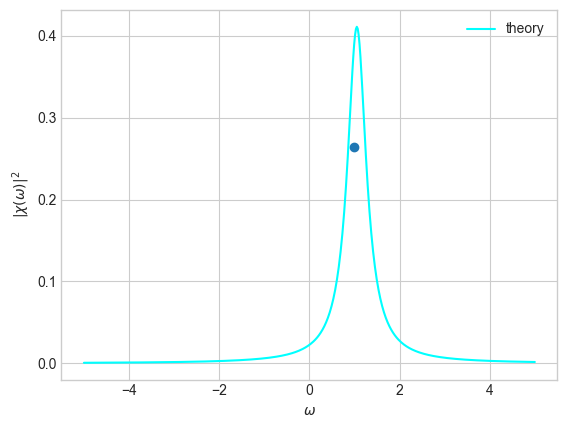

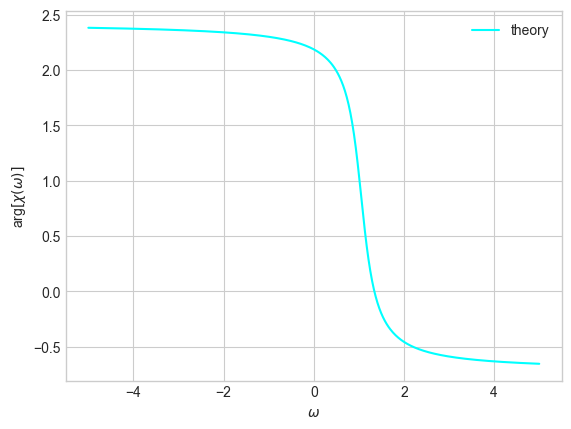

In [ ]:
### This section aims at calculating the linear response function and the susceptibility of the system for the first left hand eigenvector

# First we define the perturbation
# We want something like a sinusoidal modification of one transition rate
# We choose the last state of the first linear chain to be perturbed
perturbed_state_index = 9
def perturbation_force(t):
    return np.cos(t)
epsilon = 0.1
# Construct perturbation matrix
L_prime = np.zeros(np.shape(L))
L_prime[perturbed_state_index+1,perturbed_state_index] = 1
L_prime[perturbed_state_index,perturbed_state_index] = -1

# Since L_perturbed is now a time dependent linear transformation we have to define is as a function:
def L_perturbed(t):
    return epsilon * perturbation_force(t) * L_prime

# With that we can calculate the coefficient beta of the linear response function
beta = 0
for i in range(len(P[-1])):
    beta += Q[-2][i] * (L_prime @ P[-1])[i]


# The susceptibility is then defined by:
def chi(omega):
    return (beta)/(-eigenvals[-2].real + 1j * (omega-eigenvals[-2].imag))


### -------
# Simulation:

# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 100000
delta_t = 0.1
# perturbation frequency
omega_p = 1 # this will have to be modified later to search all frequencies
# Set number of simulations to calculate averages:
K = 1000
transient_time = 30
epsilon = 0.1

# Create trajectories
generated_time_sequence, generated_state_trajectory = gillespie_simulation_refactored(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, omega_p, epsilon)

#Perform transformation to Q_1:
Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])

chi_measured = measure_susceptibility_with_lockin(generated_time_sequence, Q_1_sequence, omega_p, epsilon, transient_time)

### -------



# Plot abs valued squared of chi as well as complex argument
freq_space = np.linspace(-5,5,500)
abs_value_squared_chi_vals = [chi(omega) * np.conjugate(chi(omega)) for omega in freq_space]
complex_arg_chi_vals = [np.angle(chi(omega)) for omega in freq_space]


plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.scatter([omega_p], [chi_measured*np.conjugate(chi_measured)])
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()

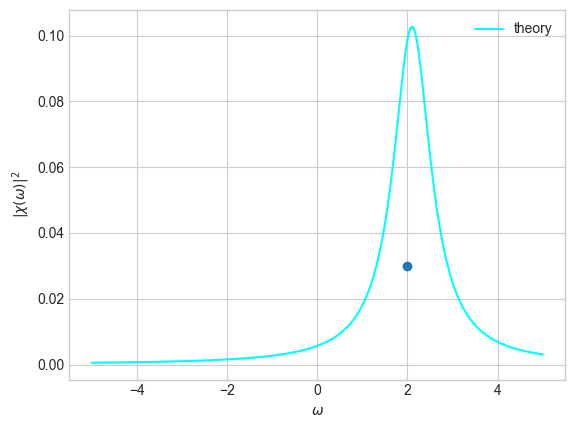

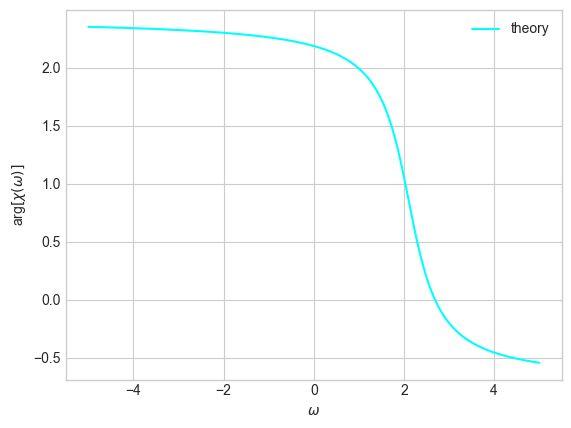

In [386]:
### This section aims at calculating the linear response function and the susceptibility of the system for the first left hand eigenvector

# First we define the perturbation
# We want something like a sinusoidal modification of one transition rate
# We choose the last state of the first linear chain to be perturbed
perturbed_state_index = 9
def perturbation_force(t):
    return np.cos(t)
epsilon = 1
# Construct perturbation matrix
L_prime = np.zeros(np.shape(L))
L_prime[perturbed_state_index+1,perturbed_state_index] = 1
L_prime[perturbed_state_index,perturbed_state_index] = -1

# Since L_perturbed is now a time dependent linear transformation we have to define is as a function:
def L_perturbed(t):
    return epsilon * perturbation_force(t) * L_prime

# With that we can calculate the coefficient beta of the linear response function
beta = 0
for i in range(len(P[-1])):
    beta += Q[-2][i] * (L_prime @ P[-1])[i]


# The susceptibility is then defined by:
def chi(omega):
    return (beta)/(-eigenvals[-2].real + 1j * (omega-eigenvals[-2].imag))


### -------
# Simulation:

# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [2,2]
refractory_periods = [1,1]
total_time = 30
delta_t = 0.01
# perturbation frequency
omega_p_vals = [2] # this will have to be modified later to search all frequencies
epsilon = 1
# Set number of simulations to calculate averages:
K = 100
# Parameter that estimates after how many oscillations the system has reached its steady state after the perturbation force is turned on
J = 0
# To calculate the susceptibility from this (in the case of a cosine perturbation) we need the averages of Q_1 at times J*2*pi and pi/(2*omega_p) + J*2*pi



# Simulation loop
chi_of_omega_p_vals = []


for omega_p in omega_p_vals:  
    t0 = np.round((2*J*np.pi/(omega_p)), int(-np.log10(delta_t)))
    t_end = t0
    while (t_end < (total_time - (2*np.pi)/(omega_p))) :
        t_end += (2*np.pi)/(omega_p)
    t0_index = int(t0/delta_t)
    t_end_index = int(t_end/delta_t)

    averages = np.zeros(t_end_index-t0_index, dtype= np.complex128)

    for i in range(K):
        # Create trajectories
        generated_time_sequence, generated_state_trajectory = gillespie_simulation_refactored(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, omega_p, epsilon = 0.1)
        #Perform transformation to Q_1:
        Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])

        averages += Q_1_sequence[t0_index:t_end_index]
        
    averages = averages/K

    prefactor = 2/(epsilon * (t_end - t0))
    integral_approx = 0
    for i in range(t_end_index-t0_index):
        integral_approx += (averages[i] * np.exp(-1j*omega_p*generated_time_sequence[t0_index:t_end_index][i])) * delta_t

    chi_of_omega_p = prefactor * integral_approx
    chi_of_omega_p_vals.append(chi_of_omega_p)

### -------



# Plot abs valued squared of chi as well as complex argument
freq_space = np.linspace(-5,5,500)
abs_value_squared_chi_vals = [chi(omega) * np.conjugate(chi(omega)) for omega in freq_space]
complex_arg_chi_vals = [np.angle(chi(omega)) for omega in freq_space]


plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.scatter(omega_p_vals, [chi_of_omega_p*np.conjugate(chi_of_omega_p) for chi_of_omega_p in chi_of_omega_p_vals])
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()


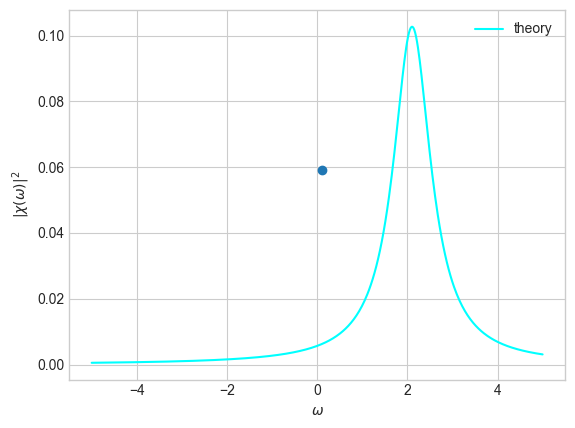

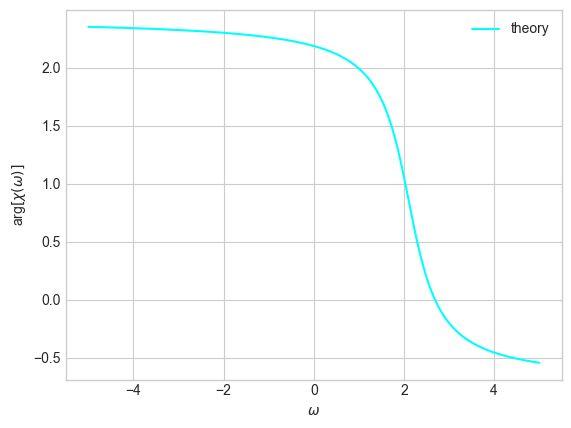

In [384]:
### This section aims at calculating the linear response function and the susceptibility of the system for the first left hand eigenvector

# First we define the perturbation
# We want something like a sinusoidal modification of one transition rate
# We choose the last state of the first linear chain to be perturbed
perturbed_state_index = 9
def perturbation_force(t):
    return np.cos(t)
epsilon = 0.1
# Construct perturbation matrix
L_prime = np.zeros(np.shape(L))
L_prime[perturbed_state_index+1,perturbed_state_index] = 1
L_prime[perturbed_state_index,perturbed_state_index] = -1

# Since L_perturbed is now a time dependent linear transformation we have to define is as a function:
def L_perturbed(t):
    return epsilon * perturbation_force(t) * L_prime

# With that we can calculate the coefficient beta of the linear response function
beta = 0
for i in range(len(P[-1])):
    beta += Q[-2][i] * (L_prime @ P[-1])[i]


# The susceptibility is then defined by:
def chi(omega):
    return (beta)/(-eigenvals[-2].real + 1j * (omega-eigenvals[-2].imag))


### -------
# Simulation:

# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 30
delta_t = 0.01
# perturbation frequency
omega_p_vals = [0.1] # this will have to be modified later to search all frequencies
epsilon = 0.1
# Set number of simulations to calculate averages:
K = 100
# Parameter that estimates after how many oscillations the system has reached its steady state after the perturbation force is turned on
J = 0
# To calculate the susceptibility from this (in the case of a cosine perturbation) we need the averages of Q_1 at times J*2*pi and pi/(2*omega_p) + J*2*pi



# Simulation loop
chi_of_omega_p_vals = []


for omega_p in omega_p_vals:  
    time_shift = np.round((np.pi)/(2*omega_p), int(-np.log10(delta_t))) 
    t0 = np.round((3*np.pi/2) + (2*J*np.pi), int(-np.log10(delta_t)))
    t_end = np.pi/2
    while (t_end < (total_time - 2*np.pi - time_shift)) :
        t_end += 2*np.pi
    t0_index = int(t0/delta_t)
    t_end_index = int(t_end/delta_t)

    t_last_required_val = t_end + time_shift
    t_last_index = int(t_last_required_val/delta_t)
    averages = np.zeros(t_last_index-t0_index, dtype= np.complex128)

    for i in range(K):
        # Create trajectories
        generated_time_sequence, generated_state_trajectory = gillespie_simulation_refactored(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, omega_p, epsilon = 0.1)
        #Perform transformation to Q_1:
        Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])

        averages += Q_1_sequence[t0_index:t_last_index]
        
    averages = averages/K

    prefactor = (1j*omega_p)/(epsilon * (np.exp(1j*omega_p*t_end) - np.exp(1j*omega_p*t0)))
    index_jump = int(time_shift/delta_t)
    integral_approx = 0
    for i in range(t_end_index-t0_index):
        integral_approx += (averages[i] - 1j * averages[i+index_jump]) * delta_t

    chi_of_omega_p = prefactor * integral_approx
    chi_of_omega_p_vals.append(chi_of_omega_p)

### -------



# Plot abs valued squared of chi as well as complex argument
freq_space = np.linspace(-5,5,500)
abs_value_squared_chi_vals = [chi(omega) * np.conjugate(chi(omega)) for omega in freq_space]
complex_arg_chi_vals = [np.angle(chi(omega)) for omega in freq_space]


plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.scatter(omega_p_vals, [chi_of_omega_p*np.conjugate(chi_of_omega_p) for chi_of_omega_p in chi_of_omega_p_vals])
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()


In [286]:
from scipy.signal import butter, filtfilt

def lock_in_amplifier(time_sequence, input_signal, target_frequency):
    # Time sequence specs
    total_time = time_sequence[-1]
    delta_t = time_sequence[1]-time_sequence[0]       #Assuming evenly spaced time array
    sampling_rate = 1/delta_t
    
    # Create reference signal for mixing
    ref_signal = np.exp(-1j * target_frequency * time_sequence)

    # Mix input and reference signal
    mixed_signal = input_signal * ref_signal

    # Now apply a low-pass filter to real and imaginary parts of mixed signal
    cutoff_frequency = 0.1 * target_frequency
    b_filter, a_filter = butter(4, cutoff_frequency, btype='low', fs=sampling_rate)
    filtered_real = filtfilt(b_filter, a_filter, mixed_signal.real)
    filtered_imag = filtfilt(b_filter, a_filter, mixed_signal.imag)
    filtered_complex = filtered_real + 1j * filtered_imag

    # Extract parameters and reconstruct signal
    if np.iscomplexobj(input_signal):
        # Input was complex, its energy is at a single frequency. No correction needed.
        correction_factor = 1.0
    else:
        # Input was real, its energy is split between +/- frequencies.
        # We only detected one half, so we multiply by 2.
        correction_factor = 2.0

    recovered_dc = correction_factor * np.mean(filtered_complex)

    recovered_amplitude = np.abs(recovered_dc)
    recovered_phase = np.angle(recovered_dc)

    return recovered_amplitude, recovered_phase

-3.022251879824949
1.5707963267948966


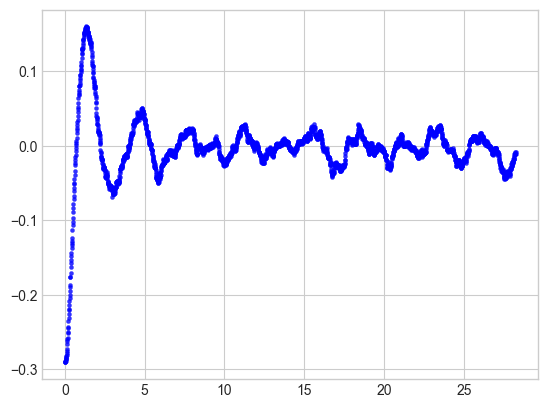

In [ ]:
## sanity check for average value of Q_1
def time_avg_Q1(t,omega_p,epsilon):
    return epsilon/2 * (np.exp(1j*omega_p*t)*chi(omega_p) + np.exp(-1j* omega_p*t) * chi(-omega_p))


omega_p = 2
epsilon = 1

# Extract target frequency with lock in amplifier
amplitude, angle = lock_in_amplifier(generated_time_sequence[t0_index:t_end_index], averages.real, omega_p)
recovered_oscillation = np.array([amplitude*np.exp(1j*omega_p*k + angle) for k in generated_time_sequence[t0_index:t_end_index]])

print(angle)
print(np.pi/2)

#plt.plot(generated_time_sequence[t0_index:t_end_index], [time_avg_Q1(t,omega_p,epsilon).real for t in generated_time_sequence[t0_index:t_end_index]], color = 'cyan')
#plt.plot(generated_time_sequence, [time_avg_Q1(t,omega_p,epsilon).imag for t in generated_time_sequence], color = 'yellow')
plt.scatter(generated_time_sequence[t0_index:t_end_index], (0.25*averages).real, linewidths=0.2, alpha=0.8, color='blue', marker = '.')
#plt.scatter(generated_time_sequence[t0_index:t_end_index], recovered_oscillation.real, linewidths=0.2, alpha=0.8, color='green', marker = '.')
#plt.scatter(generated_time_sequence[t0_index:t_last_index], (0.2*averages).imag, linewidths=0.2, alpha=0.8, color='orange')
#plt.xlim(40,60)
plt.show()

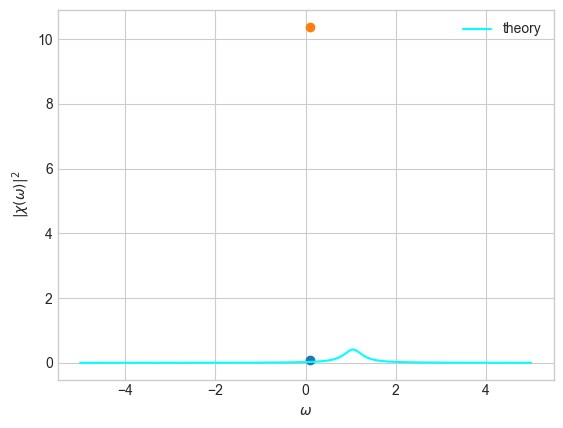

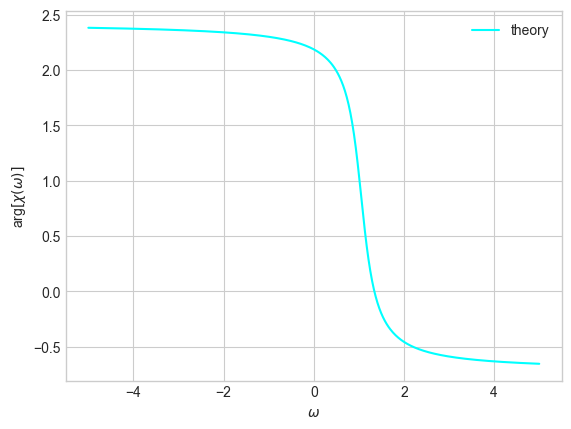

In [317]:
# Reconstruct omega from lock-in amplified recovered oscillation
omega_p = 0.1

def recovered_oscillator(t):
    return amplitude*np.exp(1j*omega_p*t + angle)

reconstructed_chi = 1/epsilon *(recovered_oscillator(10*(2*np.pi)/(omega_p)) - 1j * recovered_oscillator(10*(2*np.pi)/(omega_p) + np.pi/(2*omega_p)))

plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.scatter(omega_p_vals, [chi_of_omega_p*np.conjugate(chi_of_omega_p) for chi_of_omega_p in chi_of_omega_p_vals])
plt.scatter(omega_p, [reconstructed_chi * np.conjugate(reconstructed_chi)])
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()

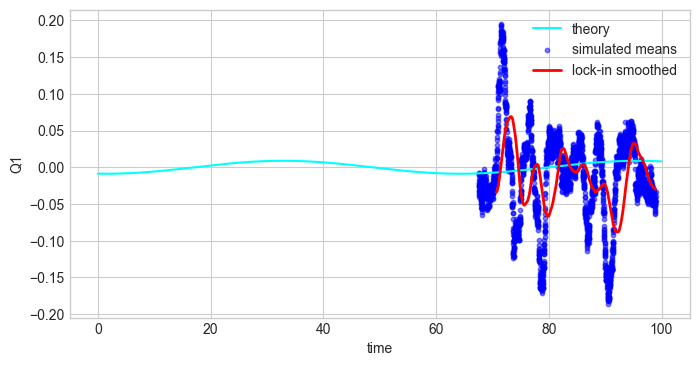

In [261]:


import numpy as np

def lockin_smooth(t, Q, omega_p, window_periods=5, max_fraction=0.1):
    """
    Sliding lock-in amplifier applied to time series Q(t).
    Returns smoothed complex signal and real reconstructed oscillation.

    Parameters
    ----------
    max_fraction : float
        Maximum fraction of array length for moving average window (default 0.5)
    """
    dt = t[1] - t[0]
    n_window = int(window_periods * 2*np.pi / omega_p / dt)
    n_window = max(1, min(n_window, int(len(Q)*max_fraction)))
    
    # multiply by reference
    Q_ref = Q * np.exp(-1j * omega_p * t)
    
    # moving average using cumulative sum
    cumsum = np.cumsum(np.insert(Q_ref, 0, 0))
    Q_smoothed = (cumsum[n_window:] - cumsum[:-n_window]) / n_window
    
    # corresponding time vector
    t_smoothed = t[n_window-1:]
    
    # reconstruct real-valued oscillation at drive frequency
    Q_reconstructed = np.real(Q_smoothed * np.exp(1j * omega_p * t_smoothed))
    
    return Q_smoothed, Q_reconstructed, t_smoothed



# Apply lock-in to your simulated means
Q_smoothed_complex, Q_reconstructed, t_smoothed = lockin_smooth(
    generated_time_sequence[t0_index:t_last_index],
    averages,
    omega_p,
    window_periods=5  # smooth over 5 drive periods
)
# Plot theoretical, raw means, and lock-in smoothed signal
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(generated_time_sequence, 
         [time_avg_Q1(t, omega_p, epsilon).real for t in generated_time_sequence], 
         color='cyan', label='theory')
plt.scatter(generated_time_sequence[t0_index:t_last_index], 
            (averages).real, s=10, alpha=0.5, color='blue', label='simulated means')
plt.plot(t_smoothed, Q_reconstructed, color='red', lw=2, label='lock-in smoothed')
plt.xlabel('time')
plt.ylabel('Q1')
plt.legend()
plt.show()


In [285]:
from scipy.signal import butter, filtfilt

def lock_in_amplifier(time_sequence, input_signal, target_frequency):
    # Time sequence specs
    total_time = time_sequence[-1]
    delta_t = time_sequence[1]-time_sequence[0]       #Assuming evenly spaced time array
    sampling_rate = 1/delta_t
    
    # Create reference signal for mixing
    ref_signal = np.exp(-1j * target_frequency * time_sequence)

    # Mix input and reference signal
    mixed_signal = input_signal * ref_signal

    # Now apply a low-pass filter to real and imaginary parts of mixed signal
    cutoff_frequency = 0.1 * target_frequency
    b_filter, a_filter = butter(4, cutoff_frequency, btype='low', fs=sampling_rate)
    filtered_real = filtfilt(b_filter, a_filter, mixed_signal.real)
    filtered_imag = filtfilt(b_filter, a_filter, mixed_signal.imag)
    filtered_complex = filtered_real + 1j * filtered_imag

    # Extract parameters and reconstruct signal
    if np.iscomplexobj(input_signal):
        # Input was complex, its energy is at a single frequency. No correction needed.
        correction_factor = 1.0
    else:
        # Input was real, its energy is split between +/- frequencies.
        # We only detected one half, so we multiply by 2.
        correction_factor = 2.0

    recovered_dc = correction_factor * np.mean(filtered_complex)

    recovered_amplitude = np.abs(recovered_dc)
    recovered_phase = np.angle(recovered_dc)

    return recovered_amplitude, recovered_phase


    

Original Amplitude (a): 2.0000
Recovered Amplitude:    2.0802

Expected Phase (rad):   0.0000
Recovered Phase (rad):  0.0081


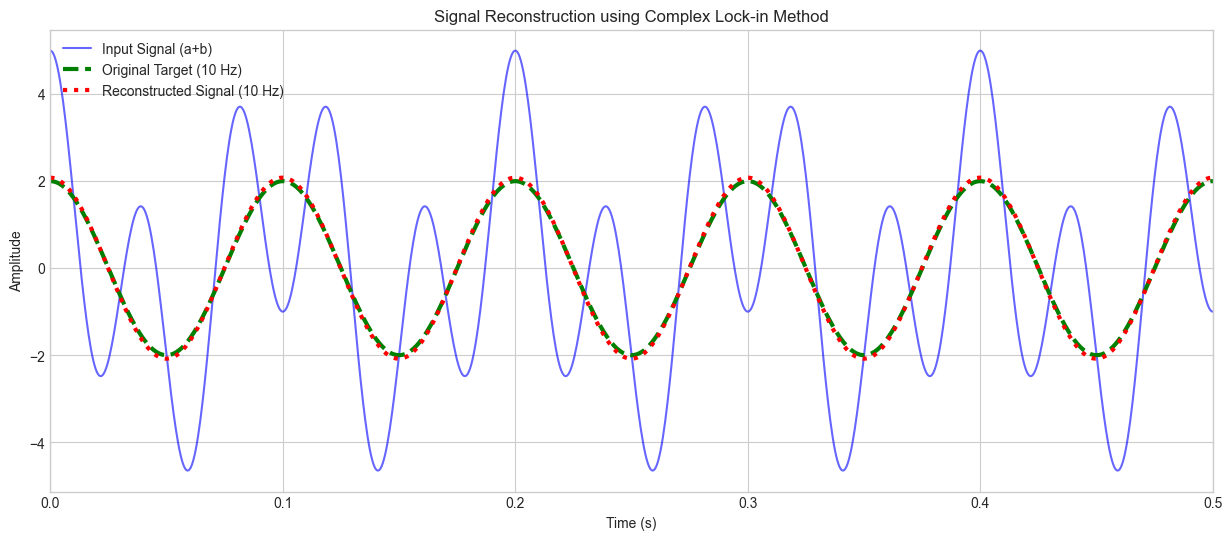

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

## 1. Setup and Signal Generation
# ------------------------------------
# Parameters are the same as before
a = 2.0
b = 3.0
f1 = 10  # Target frequency
f2 = 25
sampling_rate = 2000
duration = 4.0
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

# The input signal is still real-valued
target_signal = a * np.cos(omega1 * t)
unwanted_signal = b * np.cos(omega2 * t)
input_signal = target_signal + unwanted_signal

## 2. Lock-in Simulation (Complex Method)
# ------------------------------------
# Create ONE complex exponential reference signal
# Note the negative sign in the exponent, which is crucial for mixing
ref_signal_complex = np.exp(-1j * omega1 * t)

# Mix: a single complex multiplication
mixed_signal_complex = input_signal * ref_signal_complex

# Low-pass filter the real and imaginary parts separately
cutoff_freq = 2.0
b_filter, a_filter = butter(4, cutoff_freq, btype='low', fs=sampling_rate)
filtered_real = filtfilt(b_filter, a_filter, mixed_signal_complex.real)
filtered_imag = filtfilt(b_filter, a_filter, mixed_signal_complex.imag)

## 3. Extract Parameters and Reconstruct
# ------------------------------------
# Recombine the filtered parts and take the mean to get the complex DC value
# The factor of 2 is still needed because our real input is a cosine
recovered_complex_val = 2 * (np.mean(filtered_real) + 1j * np.mean(filtered_imag))

# Extract amplitude and phase directly from the complex number
recovered_amplitude = np.abs(recovered_complex_val)
recovered_phase = np.angle(recovered_complex_val) # Phase relative to a cosine

# Reconstruct the signal using the recovered parameters
reconstructed_signal = recovered_amplitude * np.cos(omega1 * t + recovered_phase)

## 4. Verification and Plotting ✅
# ------------------------------------
print(f"Original Amplitude (a): {a:.4f}")
print(f"Recovered Amplitude:    {recovered_amplitude:.4f}\n")

# The phase of a*cos(ωt) is 0. The recovered phase should be close to 0.
print(f"Expected Phase (rad):   0.0000")
print(f"Recovered Phase (rad):  {recovered_phase:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(t, input_signal, 'b-', label='Input Signal (a+b)', alpha=0.6)
plt.plot(t, target_signal, 'g--', lw=3, label=f'Original Target ({f1} Hz)')
plt.plot(t, reconstructed_signal, 'r:', lw=3, label=f'Reconstructed Signal ({f1} Hz)')
plt.title('Signal Reconstruction using Complex Lock-in Method')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.5)
plt.legend()
plt.grid(True)
plt.show()